In [52]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from multiscorer import *
import seaborn as sns
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in data
mx = pd.read_csv('predictive_maintenance.csv')
print('Size of predictive maintenance dataset:', mx.shape)
mx.head()

Size of predictive maintenance dataset: (10000, 10)


UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

In [3]:
mx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [4]:
mx.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25%               1423.000000     33.200000        53.000000      0.000000  
50%               1503.000000     40.100000       108.000000      0.000000  
75%               1612.000000     46.800000       162.000000      0.000000  
max               2886.000000     76.600000       253.000000      1.000000

In [5]:
print('Unique failure types')
mx['Failure Type'].value_counts()

Unique failure types


No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [6]:
print('Unique product types')
mx['Type'].value_counts()

Unique product types


L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [7]:
print('Target')
mx['Target'].value_counts()

Target


0    9661
1     339
Name: Target, dtype: int64

In [9]:
print('Unique products in dataset:', len(mx['Product ID'].unique()))

Unique products in dataset: 10000


In [10]:
# Check for duplicates
mx.duplicated().sum()

0

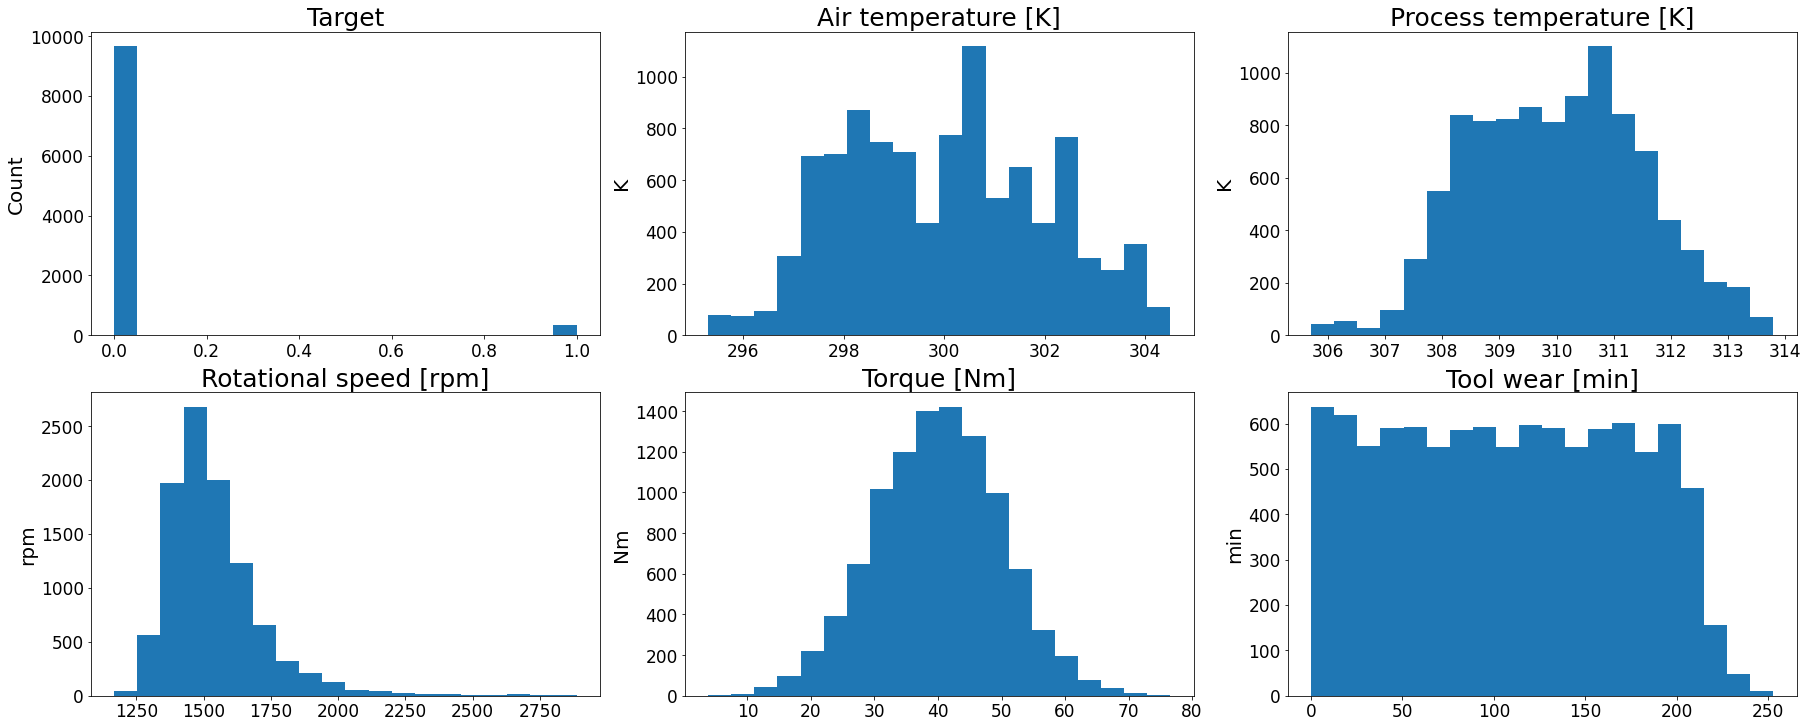

In [12]:
# Histograms
# set up the figure size
plt.rcParams['figure.figsize'] = (25, 10)

# make subplots
fig, axes = plt.subplots(nrows = 2, ncols = 3, constrained_layout=True)

# Specify the features of interest
num_features = ['Target', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
xaxes = num_features
titles = ['Target', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
yaxes = ['Count', 'K', 'K', 'rpm', 'Nm', 'min']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(mx[num_features[idx]].dropna(), bins=20)
    ax.set_title(titles[idx], fontsize=25)
    #ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=17)

plt.show()

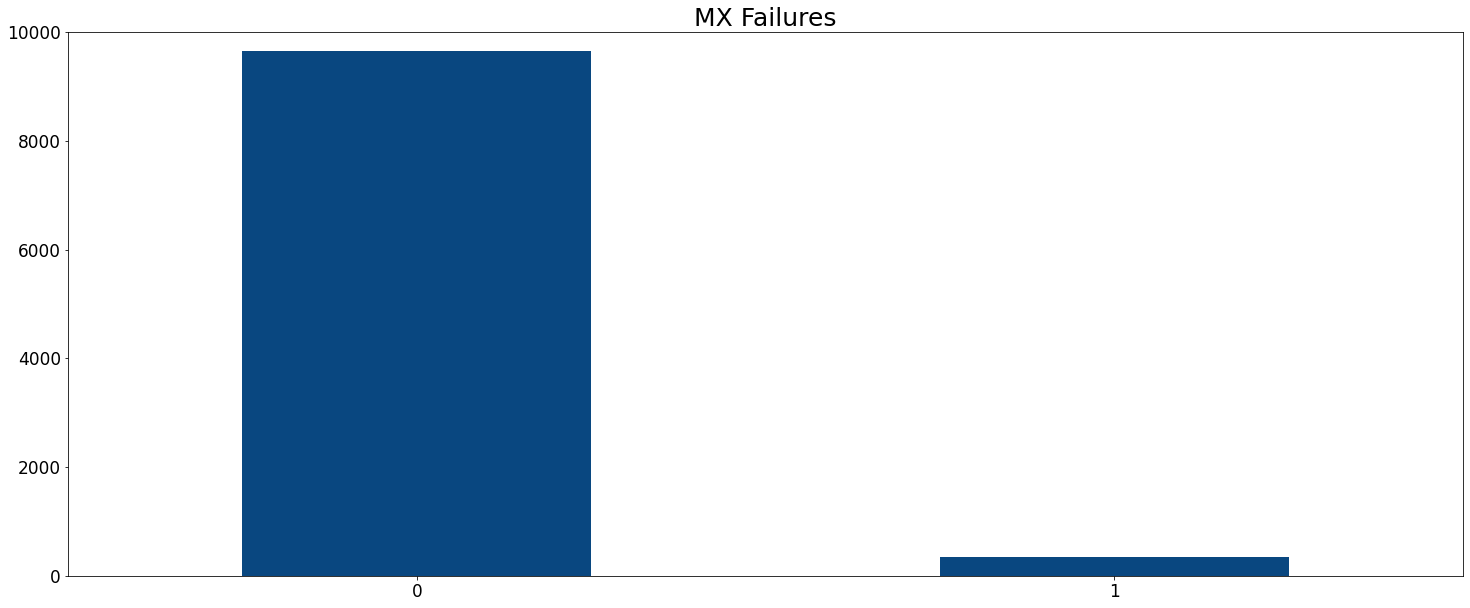

In [13]:
# target
plt.rcParams['figure.figsize'] = (25, 10)
blue1 = '#094780'

mx.Target.value_counts().plot(kind="bar", color=blue1)
plt.title('MX Failures', fontsize=25)
plt.xticks(fontsize=17, rotation=0)
plt.yticks(fontsize=17)
plt.ylim(0,10000)
plt.show()

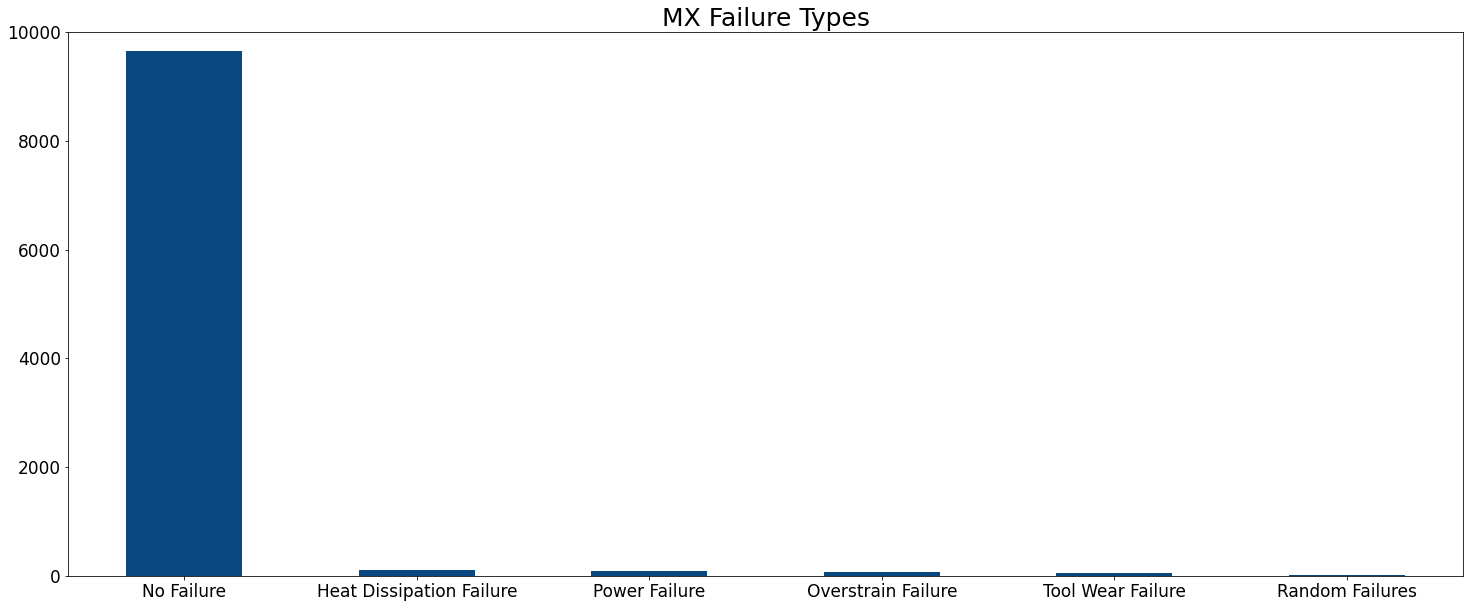

In [14]:
# failure types
plt.rcParams['figure.figsize'] = (25, 10)

mx['Failure Type'].value_counts().plot(kind="bar", color=blue1)
plt.title('MX Failure Types', fontsize=25)
plt.xticks(fontsize=17, rotation=0)
plt.yticks(fontsize=17)
plt.ylim(0,10000)
plt.show()

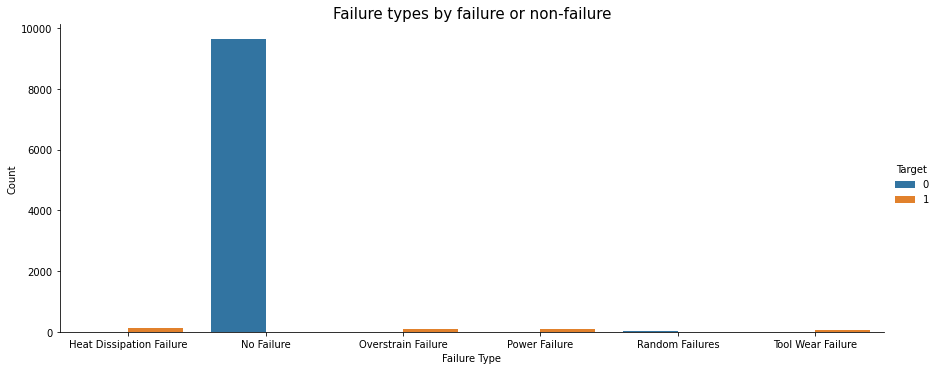

In [15]:
# failure types by target
mx_failure_type = mx['Failure Type'].value_counts().to_frame('Total')
mx_failure_type.reset_index(inplace=True)
mx_failure_type.columns = ['Failure Type', 'Total']

mx_grouped = mx.groupby('Failure Type')['Target'].value_counts().to_frame('Count')
mx_grouped.reset_index(inplace=True)
mx_grouped = pd.merge(mx_grouped, mx_failure_type, how='left', on='Failure Type')
mx_grouped['Percent'] = round((mx_grouped['Count'] / mx_grouped['Total']) * 100, 2)

# Plot
sns.catplot(x="Failure Type", y='Count', hue="Target", kind="bar", data=mx_grouped, aspect=25/10);
plt.title('Failure types by failure or non-failure', fontsize=15)
#plt.xlabel('Failure Type',fontsize=12)
#plt.ylabel('Count', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()

In [17]:
# Check data
tab = pd.pivot_table(mx, index='Failure Type', columns='Target', values='UDI', aggfunc=lambda x: len(x.unique()))
tab

Target                         0      1
Failure Type                           
Heat Dissipation Failure     NaN  112.0
No Failure                9643.0    9.0
Overstrain Failure           NaN   78.0
Power Failure                NaN   95.0
Random Failures             18.0    NaN
Tool Wear Failure            NaN   45.0

In [18]:
# Clean data
mx_cl = mx[mx['Failure Type'] != 'Random Failures']
mx_cl = mx_cl[((mx_cl['Target']==1) & (mx_cl['Failure Type']!='No Failure')) | (mx_cl['Target']==0)]
print('Before', mx.shape)
print('After', mx_cl.shape)

Before (10000, 10)
After (9973, 10)


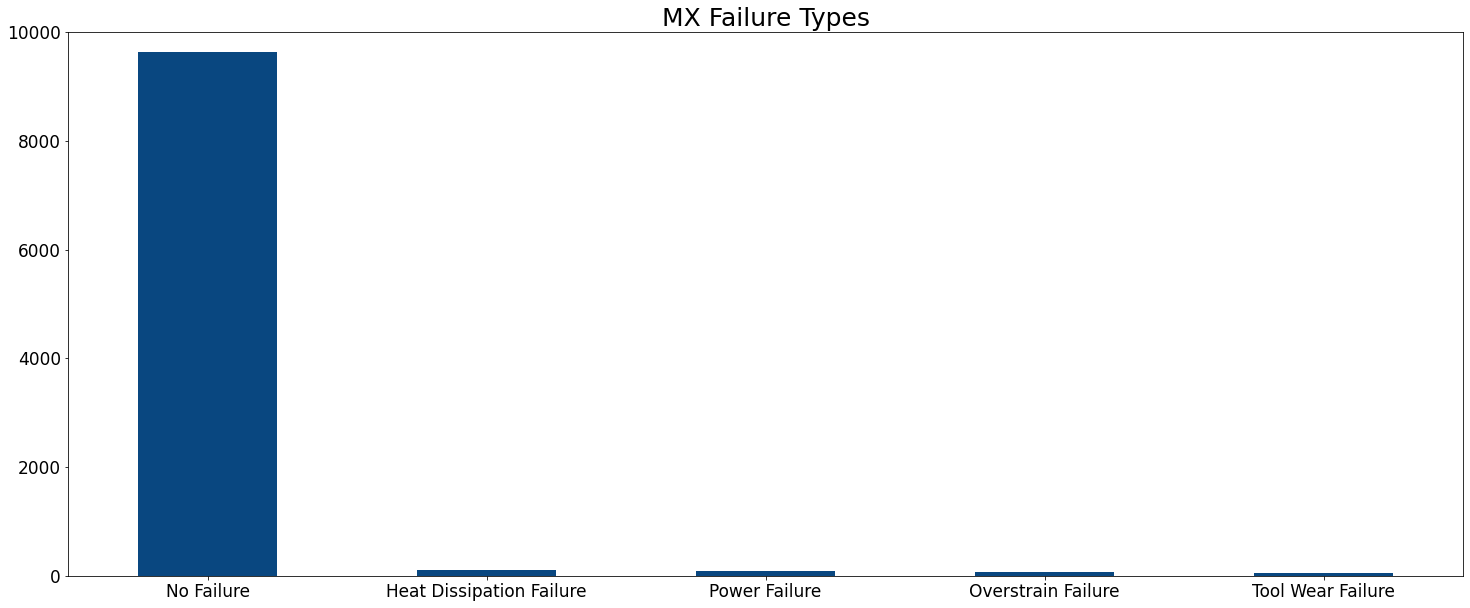

In [19]:
# Check cleaned data failure types
plt.rcParams['figure.figsize'] = (25, 10)

mx_cl['Failure Type'].value_counts().plot(kind="bar", color=blue1)
plt.title('MX Failure Types', fontsize=25)
plt.xticks(fontsize=17, rotation=0)
plt.yticks(fontsize=17)
plt.ylim(0,10000)
plt.show()

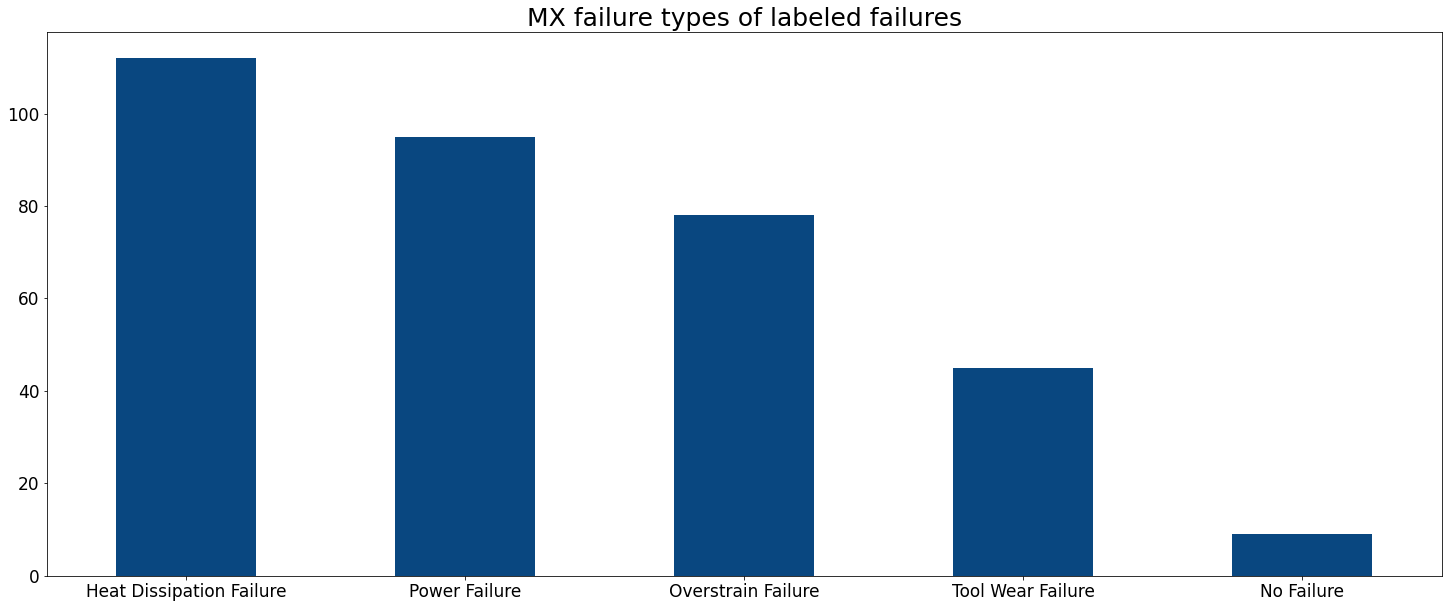

In [20]:
# Types of failures
plt.rcParams['figure.figsize'] = (25, 10)
mx_fails = mx[mx['Target']==1]
mx_fails['Failure Type'].value_counts().plot(kind="bar", color=blue1)
plt.title('MX failure types of labeled failures', fontsize=25)
plt.xticks(fontsize=17, rotation=0)
plt.yticks(fontsize=17)
plt.show()

In [21]:
mx_fails['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64

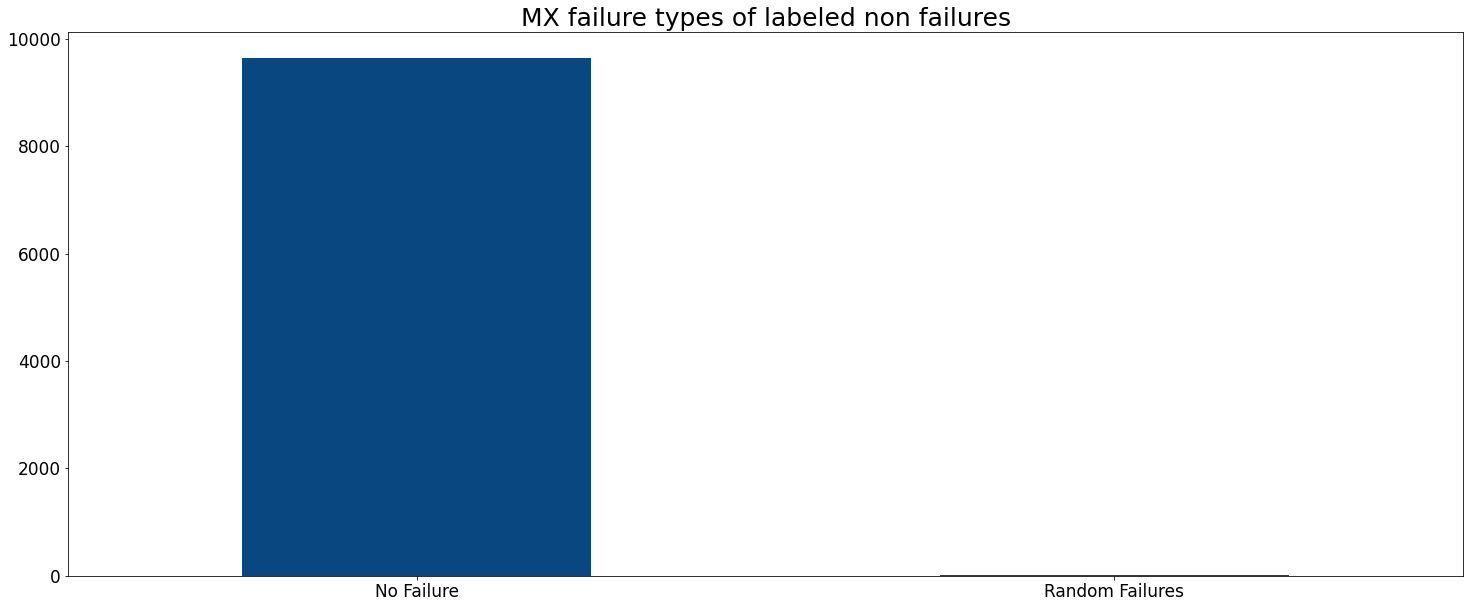

In [22]:
# Check data
plt.rcParams['figure.figsize'] = (25, 10)
mx_non_fails = mx[mx['Target']==0]
mx_non_fails['Failure Type'].value_counts().plot(kind="bar", color=blue1)
plt.title('MX failure types of labeled non failures', fontsize=25)
plt.xticks(fontsize=17, rotation=0)
plt.yticks(fontsize=17)
plt.show()

In [23]:
mx_non_fails['Failure Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64

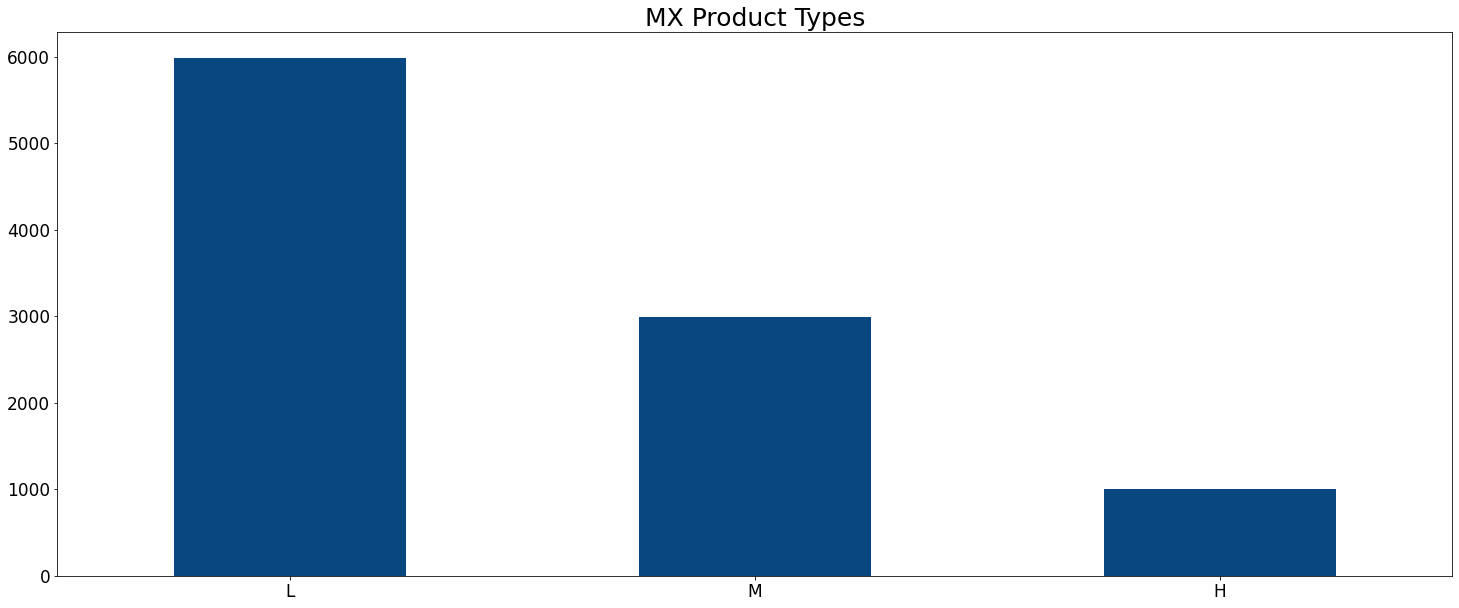

In [24]:
# Product types
plt.rcParams['figure.figsize'] = (25, 10)

mx_cl.Type.value_counts().plot(kind="bar", color=blue1)
plt.title('MX Product Types', fontsize=25)
plt.xticks(fontsize=17, rotation=0)
plt.yticks(fontsize=17)
plt.show()

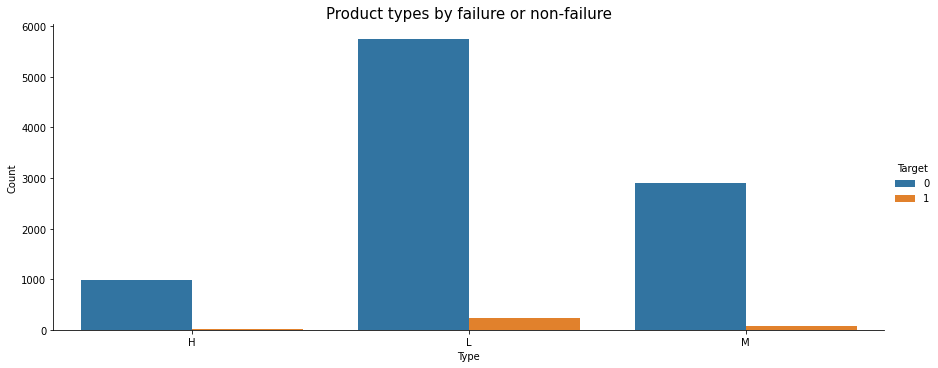

In [25]:
# product by target
mx_failure_type = mx_cl['Type'].value_counts().to_frame('Total')
mx_failure_type.reset_index(inplace=True)
mx_failure_type.columns = ['Type', 'Total']

mx_grouped = mx_cl.groupby('Type')['Target'].value_counts().to_frame('Count')
mx_grouped.reset_index(inplace=True)
mx_grouped = pd.merge(mx_grouped, mx_failure_type, how='left', on='Type')
mx_grouped['Percent'] = round((mx_grouped['Count'] / mx_grouped['Total']) * 100, 2)

# Plot
sns.catplot(x="Type", y='Count', hue="Target", kind="bar", data=mx_grouped, aspect=25/10);
plt.title('Product types by failure or non-failure', fontsize=15)
#plt.xlabel('Failure Type',fontsize=12)
#plt.ylabel('Count', fontsize=12)
plt.tick_params(labelsize=10)
plt.show()

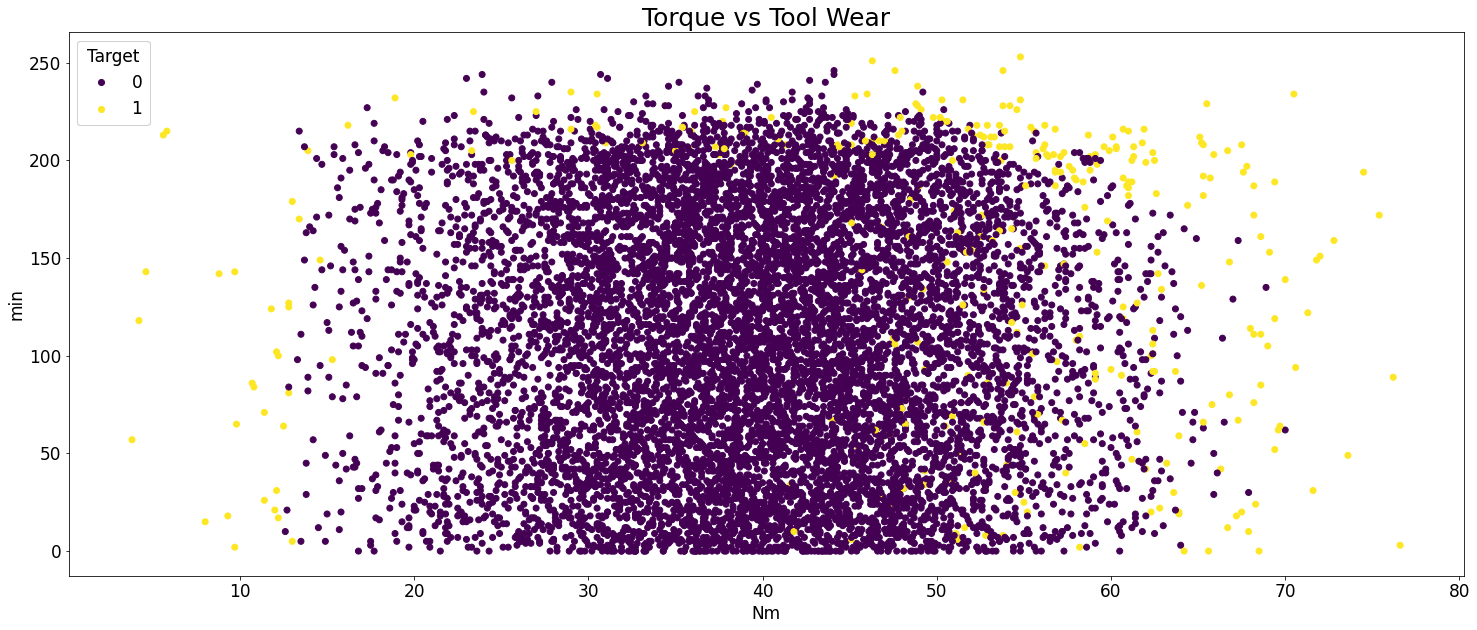

In [26]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Torque [Nm]']), np.array(mx_cl['Tool wear [min]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Torque vs Tool Wear', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('Nm',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('min', fontsize=17)
plt.show()

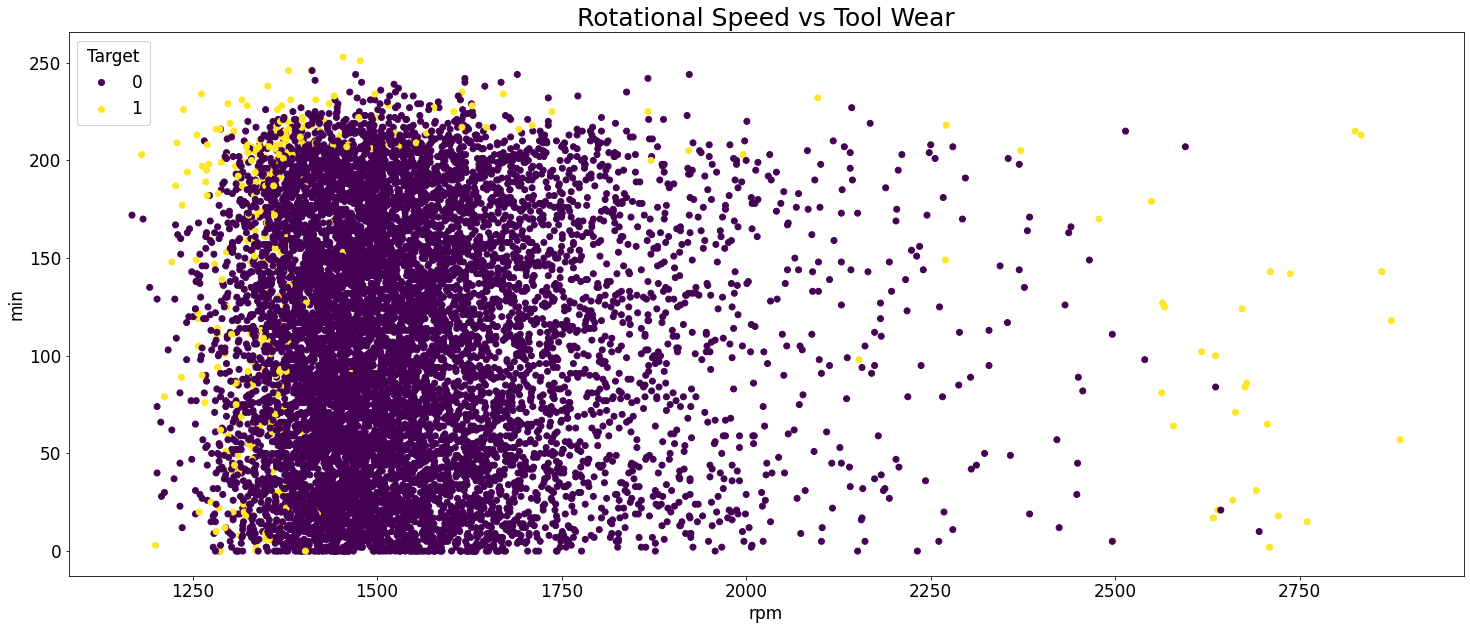

In [27]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Rotational speed [rpm]']), np.array(mx_cl['Tool wear [min]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Rotational Speed vs Tool Wear', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('rpm',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('min', fontsize=17)
plt.show()

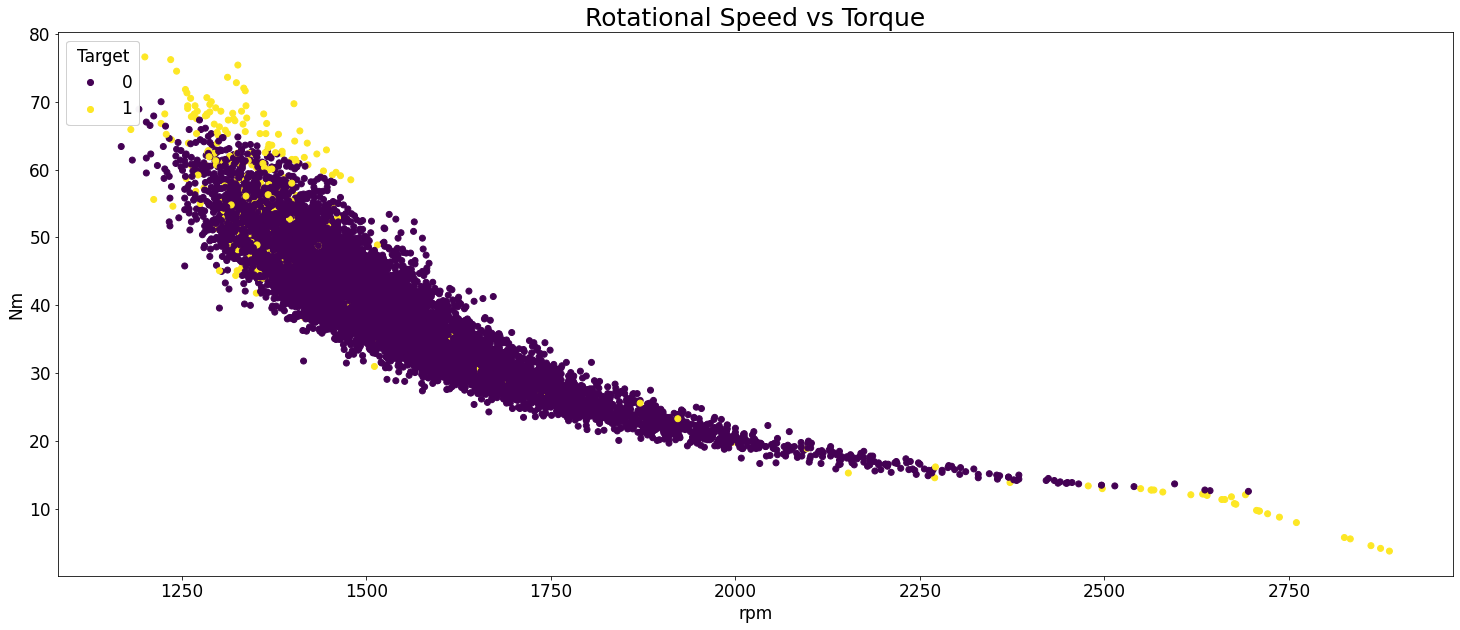

In [28]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Rotational speed [rpm]']), np.array(mx_cl['Torque [Nm]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Rotational Speed vs Torque', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('rpm',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Nm', fontsize=17)
plt.show()

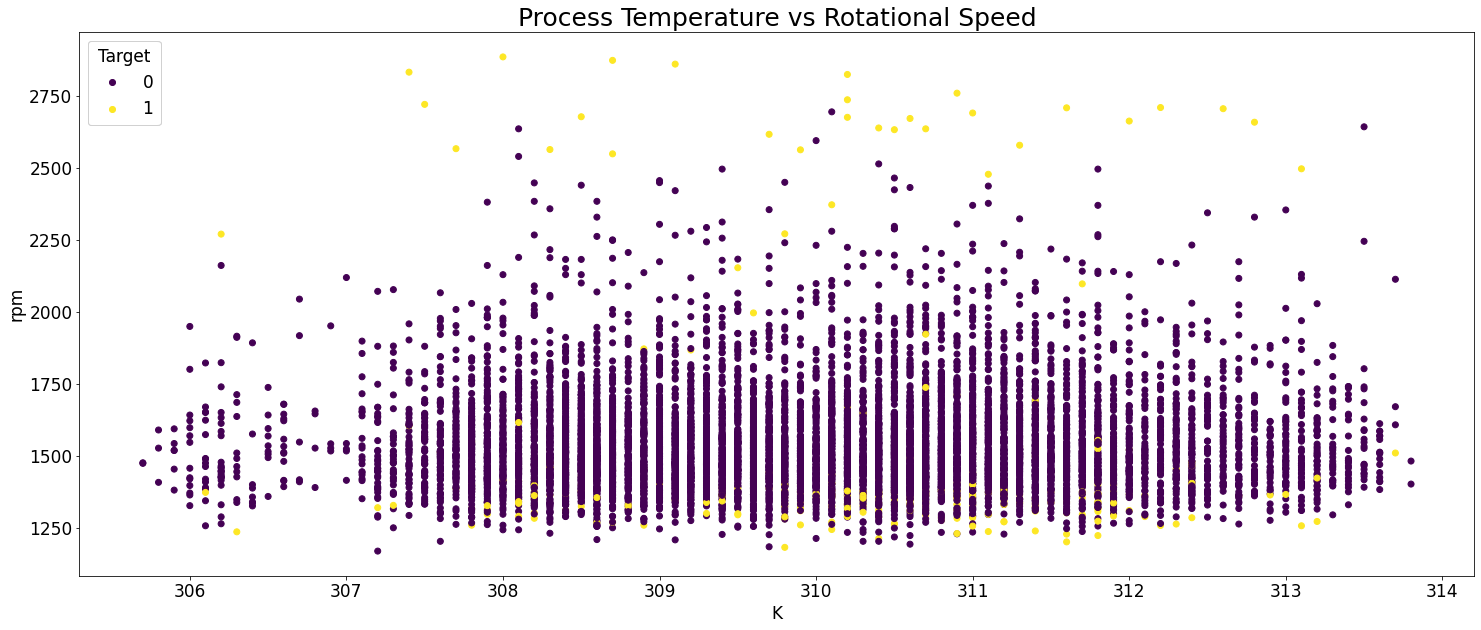

In [29]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Process temperature [K]']), np.array(mx_cl['Rotational speed [rpm]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Process Temperature vs Rotational Speed', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('K',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('rpm', fontsize=17)
plt.show()

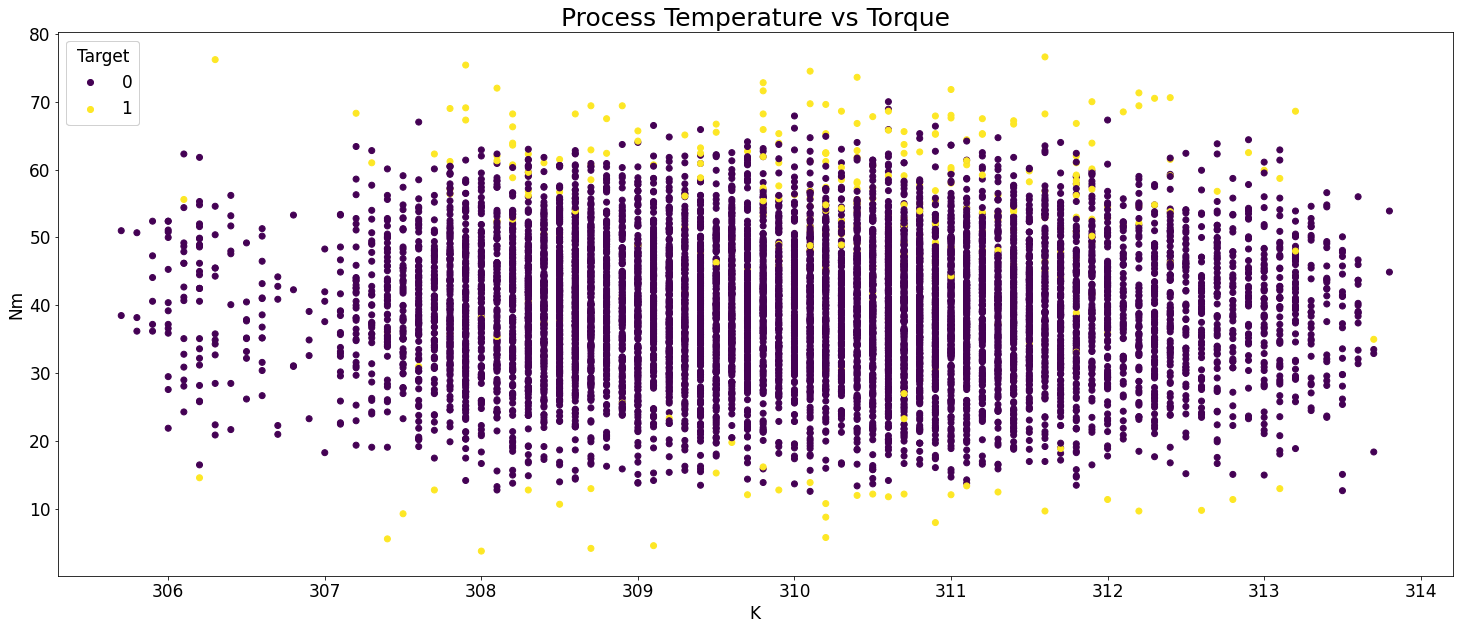

In [30]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Process temperature [K]']), np.array(mx_cl['Torque [Nm]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Process Temperature vs Torque', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('K',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Nm', fontsize=17)
plt.show()

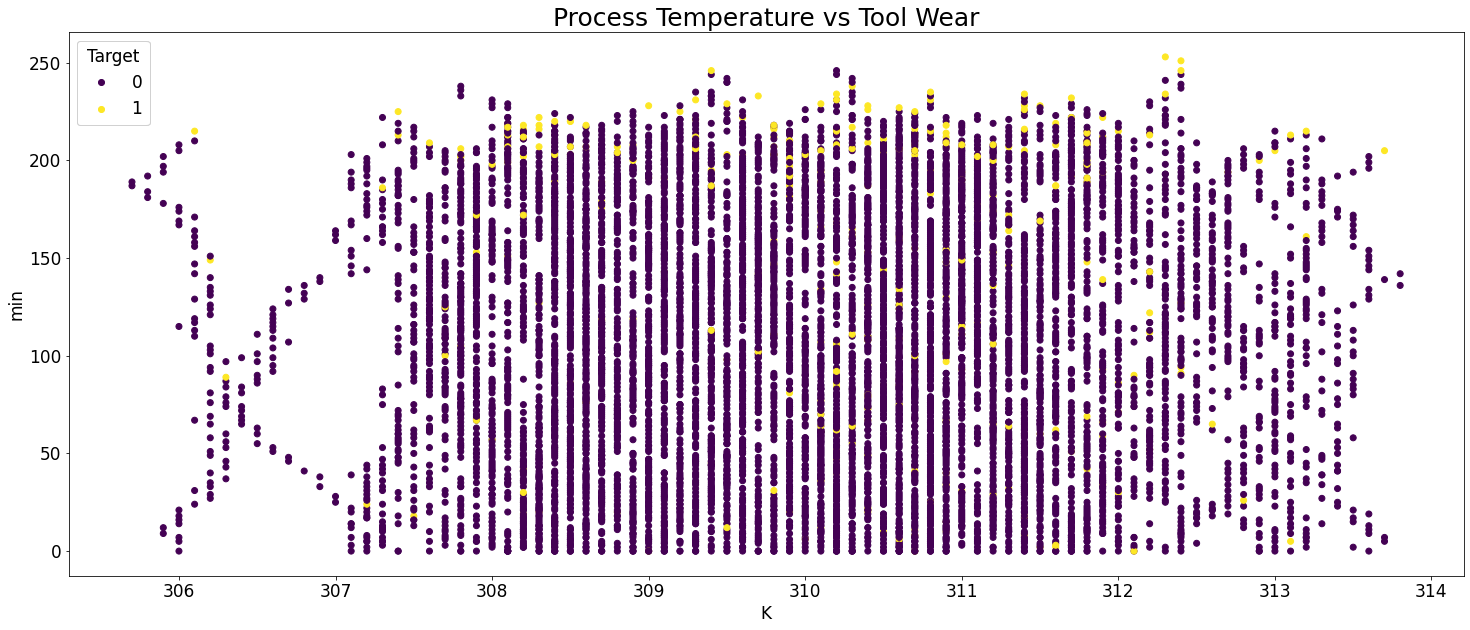

In [31]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Process temperature [K]']), np.array(mx_cl['Tool wear [min]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Process Temperature vs Tool Wear', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('K',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('min', fontsize=17)
plt.show()

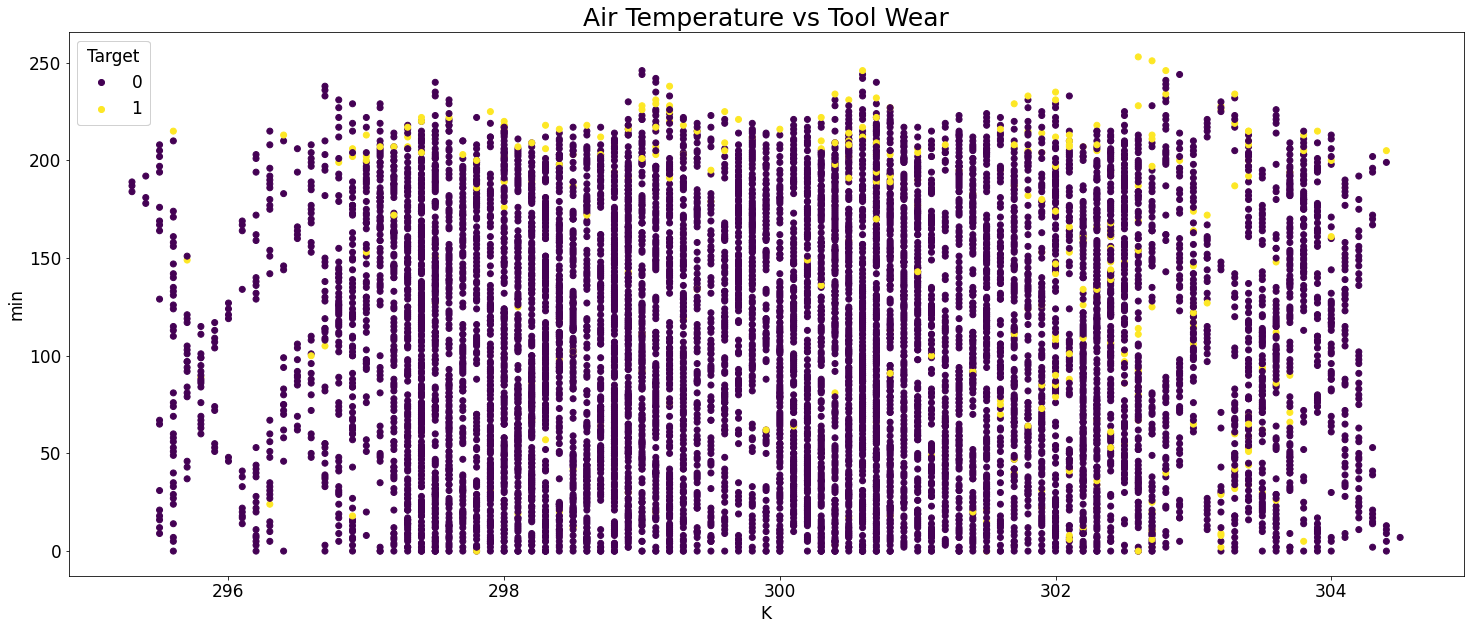

In [32]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Air temperature [K]']), np.array(mx_cl['Tool wear [min]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Air Temperature vs Tool Wear', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('K',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('min', fontsize=17)
plt.show()

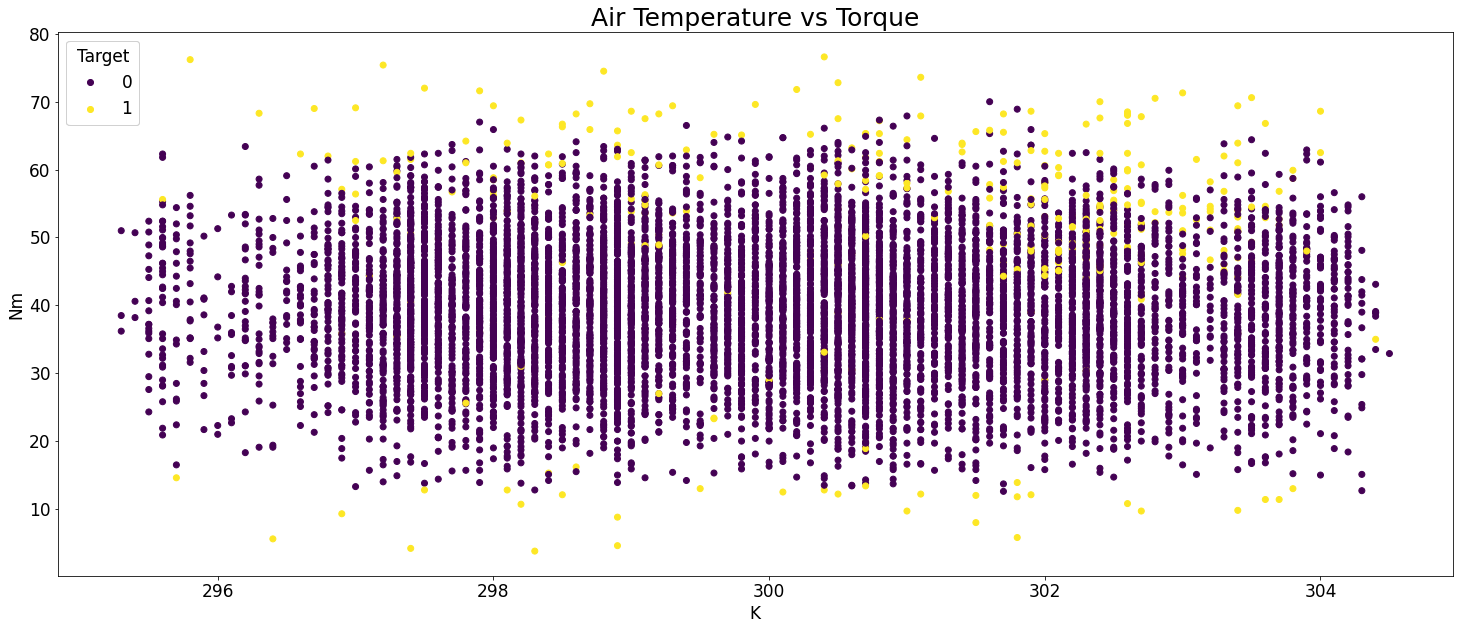

In [33]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Air temperature [K]']), np.array(mx_cl['Torque [Nm]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Air Temperature vs Torque', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('K',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Nm', fontsize=17)
plt.show()

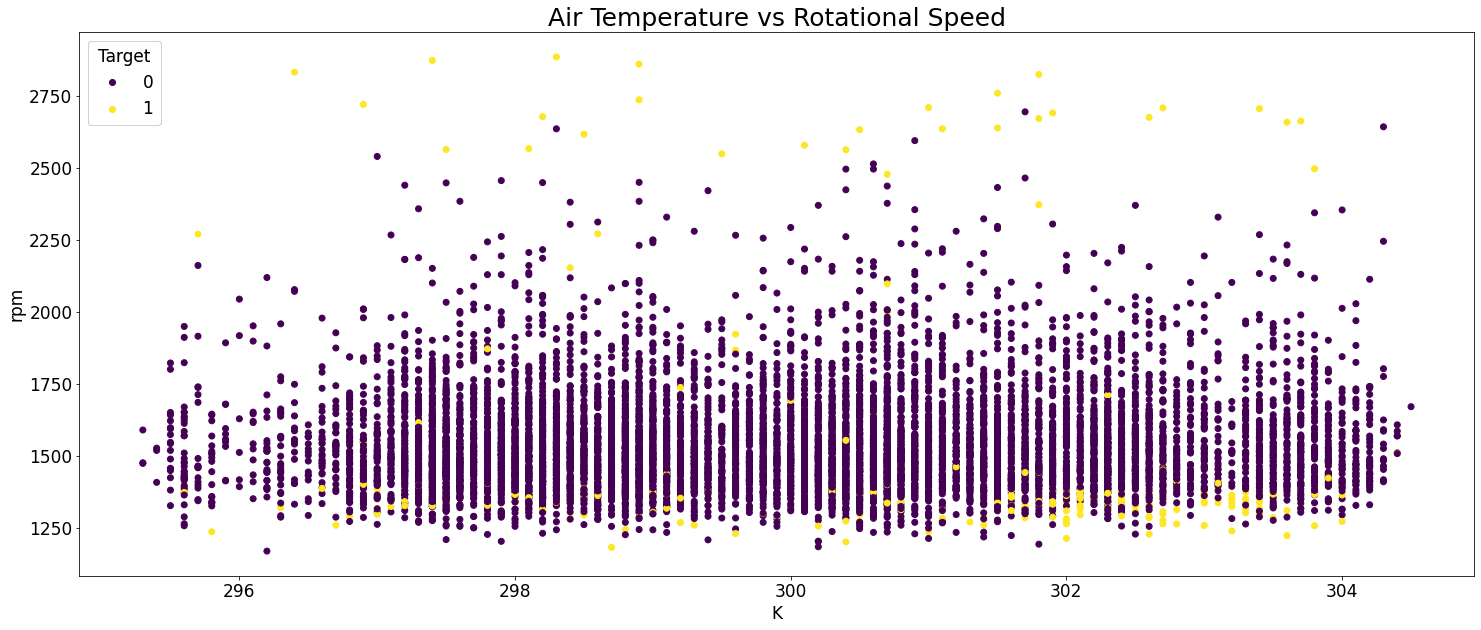

In [34]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Air temperature [K]']), np.array(mx_cl['Rotational speed [rpm]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Air Temperature vs Rotational Speed', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('K',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('rpm', fontsize=17)
plt.show()

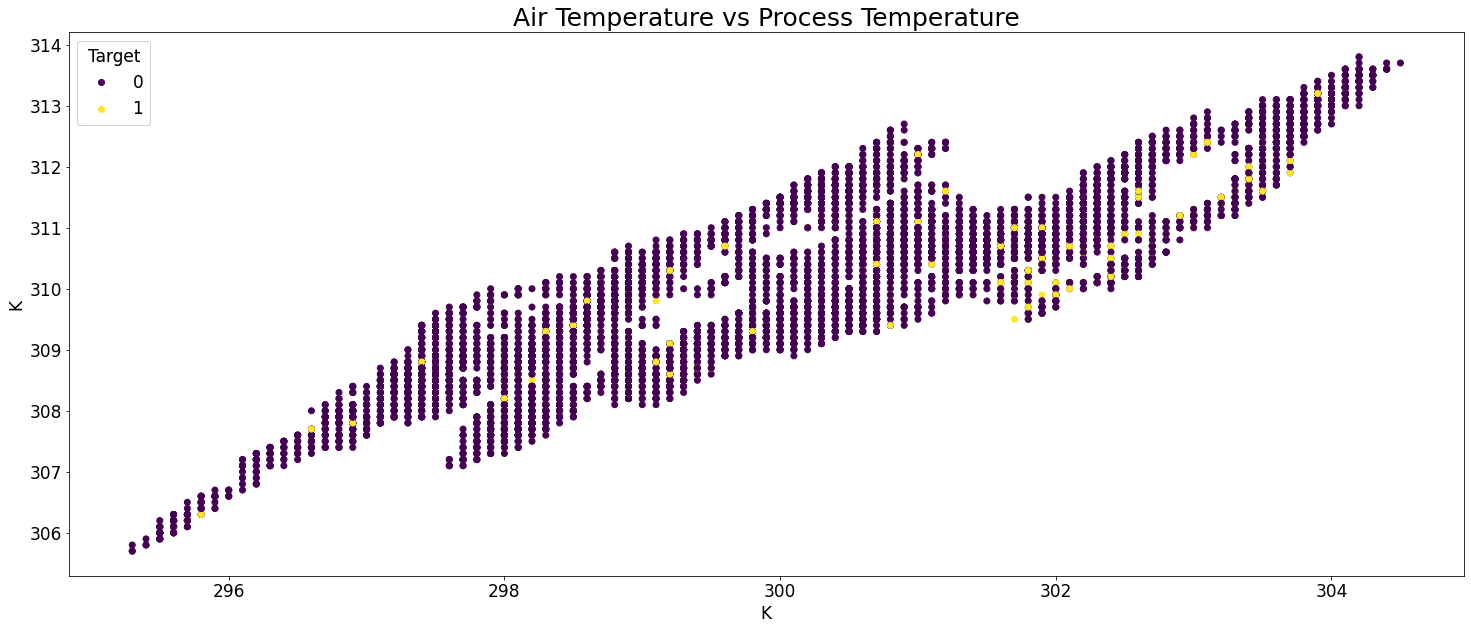

In [35]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(mx_cl['Air temperature [K]']), np.array(mx_cl['Process temperature [K]']), c=mx_cl['Target'])
legend1 = ax.legend(*scatter.legend_elements(num=1),
                    loc="upper left", title="Target", fontsize=17, title_fontsize=17)
ax.add_artist(legend1)
plt.title('Air Temperature vs Process Temperature', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('K',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('K', fontsize=17)
plt.show()

In [37]:
# Drop columns for modeling
mx_cl = mx_cl.drop(['UDI', 'Product ID', 'Failure Type'], axis=1)
mx_cl.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target  
0         42.8                0       0  
1         46.3                3       0  
2         49.4                5       0  
3         39.5                7       0  
4         40.0                9       0

In [38]:
# Convert categorical data to numbers
cat_features = ['Type']
data_cat = mx_cl[cat_features]
# One Hot Encoding 
data_cat_dummies = pd.get_dummies(data_cat)
# Join one hot encoded features back on
mx_cl = mx_cl.join(data_cat_dummies, how='left')
mx_cl = mx_cl.drop(cat_features, axis=1)
mx_cl.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target  Type_H  Type_L  Type_M  
0         42.8                0       0       0       0       1  
1         46.3                3       0       0       1       0  
2         49.4                5       0       0       1       0  
3         39.5                7       0       0       1       0  
4         40.0                9       0       0       1       0

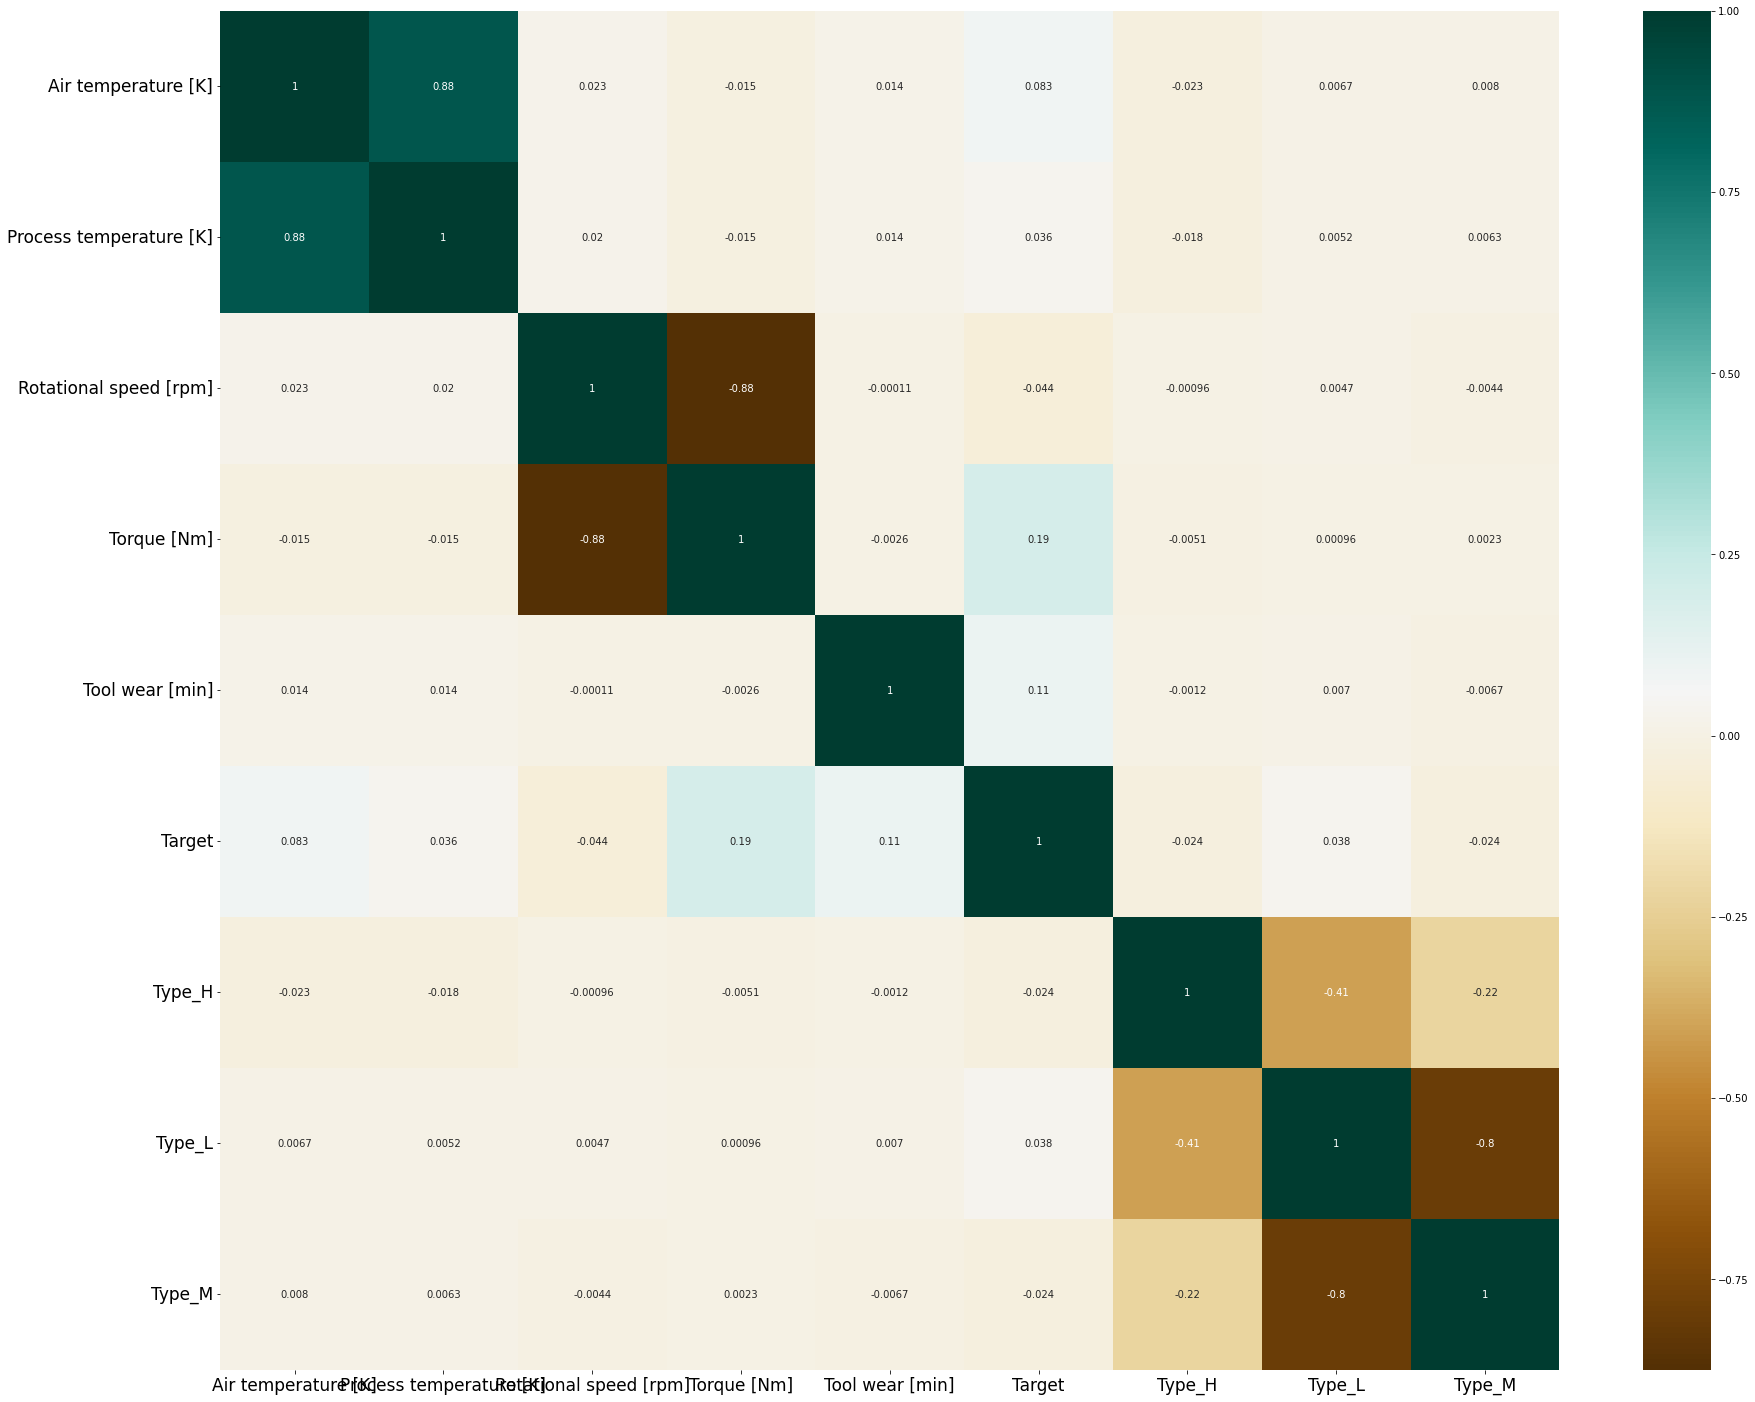

In [39]:
# Plot heat map
c = mx_cl.corr()
plt.figure(figsize=(30,25))
sns.heatmap(c,cmap='BrBG',annot=True)
plt.tick_params(labelsize=17)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

In [42]:
# Oversampling
os = SMOTE(random_state=0)

X = mx_cl.loc[:, mx_cl.columns != 'Target']
y = mx_cl.loc[:, mx_cl.columns == 'Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Target'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of non failure in oversampled data",len(os_data_y[os_data_y['Target']==0]))
print("Number of failure",len(os_data_y[os_data_y['Target']==1]))
print("Proportion of non failure data in oversampled data is ",len(os_data_y[os_data_y['Target']==0])/len(os_data_X))
print("Proportion of failure data in oversampled data is ",len(os_data_y[os_data_y['Target']==1])/len(os_data_X))

length of oversampled data is  13508
Number of non failure in oversampled data 6754
Number of failure 6754
Proportion of non failure data in oversampled data is  0.5
Proportion of failure data in oversampled data is  0.5


logreg1 - Logistic Regression: No Hyper Parameter Tuning

Accuracy on test set: 0.87
-------------------------------------------------------
Confusion Matrix
pred       0    1
Target           
0       2541  348
1         33   70

True Predictions:  2611
False Predictions:  381
-------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      2889
           1       0.17      0.68      0.27       103

    accuracy                           0.87      2992
   macro avg       0.58      0.78      0.60      2992
weighted avg       0.96      0.87      0.91      2992



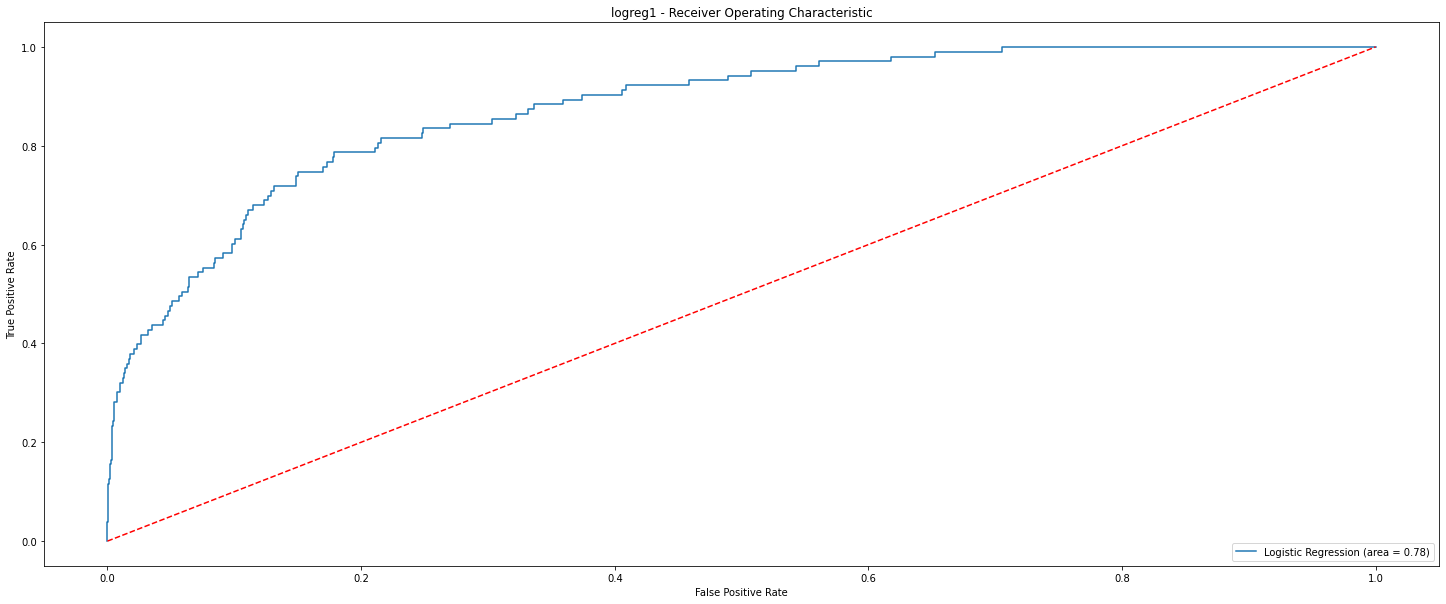

In [63]:
# logreg1
logreg1 = LogisticRegression()
logreg1.fit(os_data_X, os_data_y)
logreg1_pred = logreg1.predict(X_test)
logreg1_prob = logreg1.predict_proba(X_test)
print('logreg1 - Logistic Regression: No Hyper Parameter Tuning\n')
print('Accuracy on test set: {:.2f}'.format(logreg1.score(X_test, y_test)))
print('-------------------------------------------------------')
logreg1_confusion_matrix = pd.crosstab(y_test['Target'].to_numpy(), logreg1_pred, rownames=['Target'], colnames=['pred'])
print('Confusion Matrix')
print(logreg1_confusion_matrix)

logreg1_tn = logreg1_confusion_matrix.iloc[0][0] 
logreg1_tp = logreg1_confusion_matrix.iloc[1][1]
logreg1_true_preds = logreg1_tn + logreg1_tp
print('\nTrue Predictions: ', logreg1_true_preds)

logreg1_fp = logreg1_confusion_matrix.iloc[0][1]
logreg1_fn = logreg1_confusion_matrix.iloc[1][0]
logreg1_false_preds = logreg1_fp + logreg1_fn
print('False Predictions: ', logreg1_false_preds)

print('-------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test['Target'], logreg1_pred))

# ROC Plot
logreg1_roc_auc = roc_auc_score(y_test, logreg1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logreg1_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('logreg1 - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [44]:
print('Accuracy on test set: {:.2f}'.format(logreg1.score(os_data_X, os_data_y)))

Accuracy on test set: 0.88


Feature: 0, Score: 1.20766
Feature: 1, Score: -1.26126
Feature: 2, Score: 0.01066
Feature: 3, Score: 0.27478
Feature: 4, Score: 0.01608
Feature: 5, Score: -2.09921
Feature: 6, Score: -2.30939
Feature: 7, Score: -4.65464


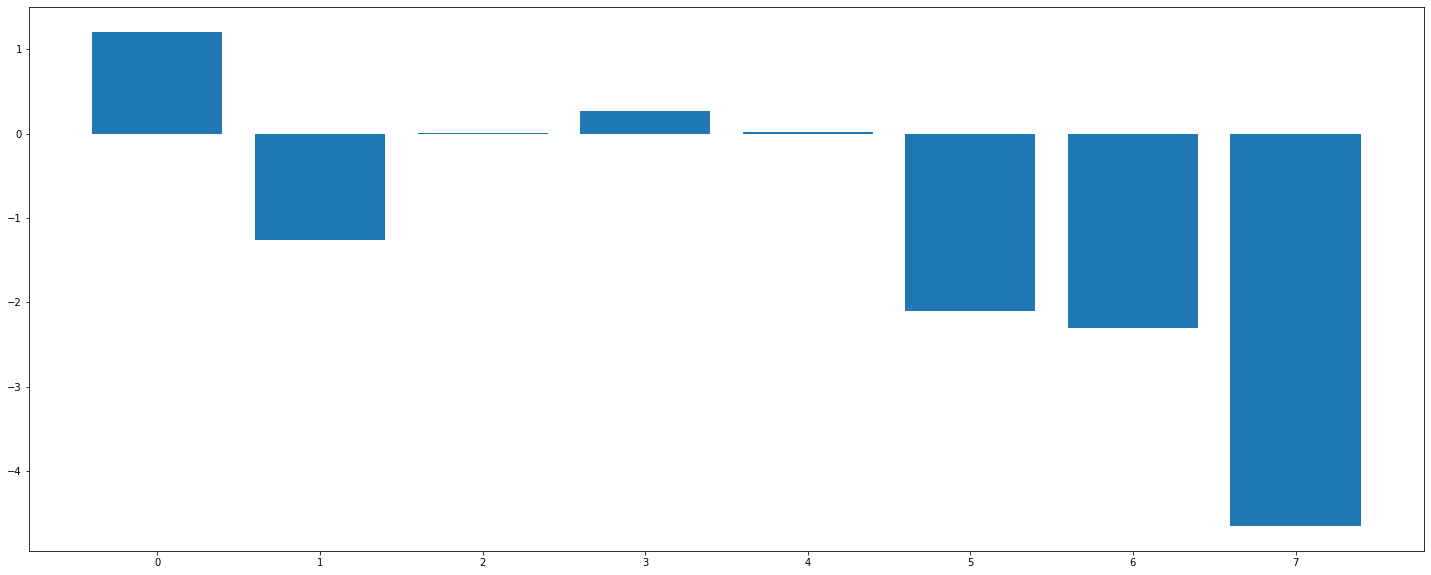

In [46]:
# get importance
cols = os_data_X.columns
importance = logreg1.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [47]:
os_data_X.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Type_H',
       'Type_L', 'Type_M'],
      dtype='object')

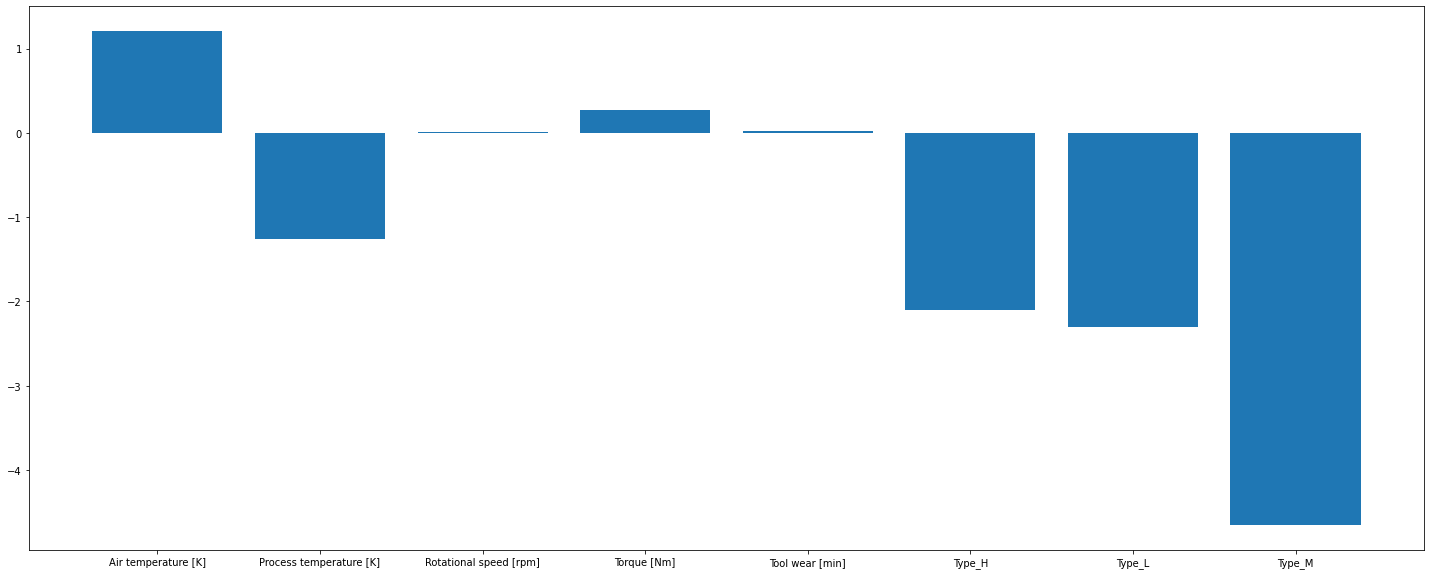

In [45]:
# Add labels
x = os_data_X.columns
y = [1.20766, -1.26126, 0.01066, 0.27478, 0.01608, -2.09921, -2.30939, -4.65464]
plt.bar(x,y)
plt.show()

In [64]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

# Measuring the metrics of the different models
scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })
# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : []
                    }
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    _ = cross_val_score(model, os_data_X, os_data_y, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        print('%s : %f' %(metric_name, average_score))

        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "recall", "precision"], ascending=False)

LogisticRegression
accuracy : 0.886438
f1_score : 0.886431
recall : 0.886502
precision : 0.886640
GaussianNB
accuracy : 0.829471
f1_score : 0.826353
recall : 0.829506
precision : 0.845825
RandomForestClassifier
accuracy : 0.878714
f1_score : 0.876634
recall : 0.878738
precision : 0.889687
SVC
accuracy : 0.868263
f1_score : 0.866597
recall : 0.868283
precision : 0.877373
DecisionTreeClassifier
accuracy : 0.887474
f1_score : 0.886141
recall : 0.887493
precision : 0.894765
KNeighborsClassifier
accuracy : 0.895741
f1_score : 0.894608
recall : 0.895757
precision : 0.902419


accuracy  f1_score    recall  precision
model_name                                                     
KNeighborsClassifier    0.895741  0.894608  0.895757   0.902419
DecisionTreeClassifier  0.887474  0.886141  0.887493   0.894765
LogisticRegression      0.886438  0.886431  0.886502   0.886640
RandomForestClassifier  0.878714  0.876634  0.878738   0.889687
SVC                     0.868263  0.866597  0.868283   0.877373
GaussianNB              0.829471  0.826353  0.829506   0.845825

In [53]:
%%capture --no-display

# Initialize model
logreg2 = LogisticRegression()

# Parameters to search
logreg_space = dict()
logreg_space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
logreg_space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
logreg_space['C'] = loguniform(1e-5, 100)

# Randomized search
logreg2_rscv = RandomizedSearchCV(logreg2, logreg_space, n_iter=500, cv=3, scoring='accuracy')

# Search for best model
logreg2_hp1 = logreg2_rscv.fit(os_data_X, os_data_y)

# Fit model
logreg2_hp1.fit(os_data_X, os_data_y)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=500,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000012746EA5840>,
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='accuracy')

logreg2_hp1 - Logistic Regression: No Hyper Parameter Tuning

Accuracy on test set: 0.89
-------------------------------------------------------
Confusion Matrix
pred       0    1
Target           
0       2604  285
1         35   68

True Predictions:  2672
False Predictions:  320
-------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2889
           1       0.19      0.66      0.30       103

    accuracy                           0.89      2992
   macro avg       0.59      0.78      0.62      2992
weighted avg       0.96      0.89      0.92      2992

Threshold: [1.99665763e+00 9.96657633e-01 9.90978856e-01 9.90458358e-01
 9.83828548e-01 9.80731790e-01 9.79333285e-01 9.77675303e-01
 9.66562123e-01 9.65225767e-01 9.58239111e-01 9.54035406e-01
 9.52087275e-01 9.51405793e-01 9.42695902e-01 9.42645540e-01
 9.41667323e-01 9.41479073e-01 9.40417855e-01 9.15341574e

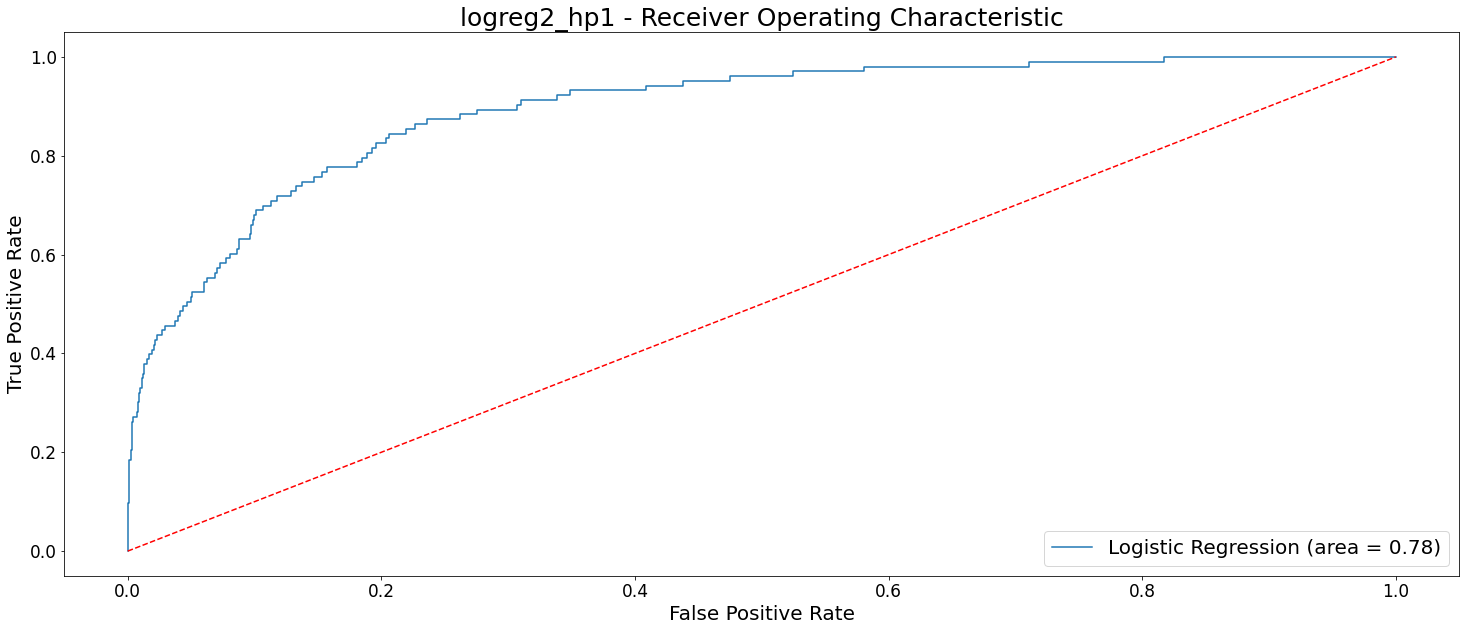

In [65]:
# Predict
logreg2_pred = logreg2_hp1.predict(X_test)
logreg2_prob = logreg2_hp1.predict_proba(X_test)
print('logreg2_hp1 - Logistic Regression: No Hyper Parameter Tuning\n')
print('Accuracy on test set: {:.2f}'.format(logreg2_hp1.score(X_test, y_test)))
print('-------------------------------------------------------')
logreg2_confusion_matrix = pd.crosstab(y_test['Target'].to_numpy(), logreg2_pred, rownames=['Target'], colnames=['pred'])
print('Confusion Matrix')
print(logreg2_confusion_matrix)

logreg2_tn = logreg2_confusion_matrix.iloc[0][0] 
logreg2_tp = logreg2_confusion_matrix.iloc[1][1]
logreg2_true_preds = logreg2_tn + logreg2_tp
print('\nTrue Predictions: ', logreg2_true_preds)

logreg2_fp = logreg2_confusion_matrix.iloc[0][1]
logreg2_fn = logreg2_confusion_matrix.iloc[1][0]
logreg2_false_preds = logreg2_fp + logreg2_fn
print('False Predictions: ', logreg2_false_preds)

print('-------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test['Target'], logreg2_pred))

# ROC Plot
logreg2_roc_auc = roc_auc_score(y_test, logreg2_hp1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg2_hp1.predict_proba(X_test)[:,1])
print('Threshold:', thresholds)
print('AUC:', round(metrics.auc(fpr, tpr),2))
plt.figure()
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logreg2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('logreg2_hp1 - Receiver Operating Characteristic',fontsize=25)
plt.legend(loc="lower right",fontsize=20)
plt.tick_params(labelsize=17)
plt.savefig('Log_ROC')
plt.show()

In [ ]:
# List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
# Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# Create new KNN object
knn_2 = KNeighborsClassifier()
# Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# Fit the model
best_model = clf.fit(os_data_X,os_data_y)
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
# Put results of this cell in a markdown because the warnings when running it took up a lot of room

Best leaf_size: 1

Best p: 1

Best n_neighbors: 2

KNN - Hyper Parameter Tuning

Accuracy on test set: 0.93
-------------------------------------------------------
Confusion Matrix
pred       0    1
Target           
0       2732  157
1         50   53

True Predictions:  2785
False Predictions:  207
-------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2889
           1       0.25      0.51      0.34       103

    accuracy                           0.93      2992
   macro avg       0.62      0.73      0.65      2992
weighted avg       0.96      0.93      0.94      2992

Threshold: [2.  1.  0.5 0. ]
AUC: 0.8


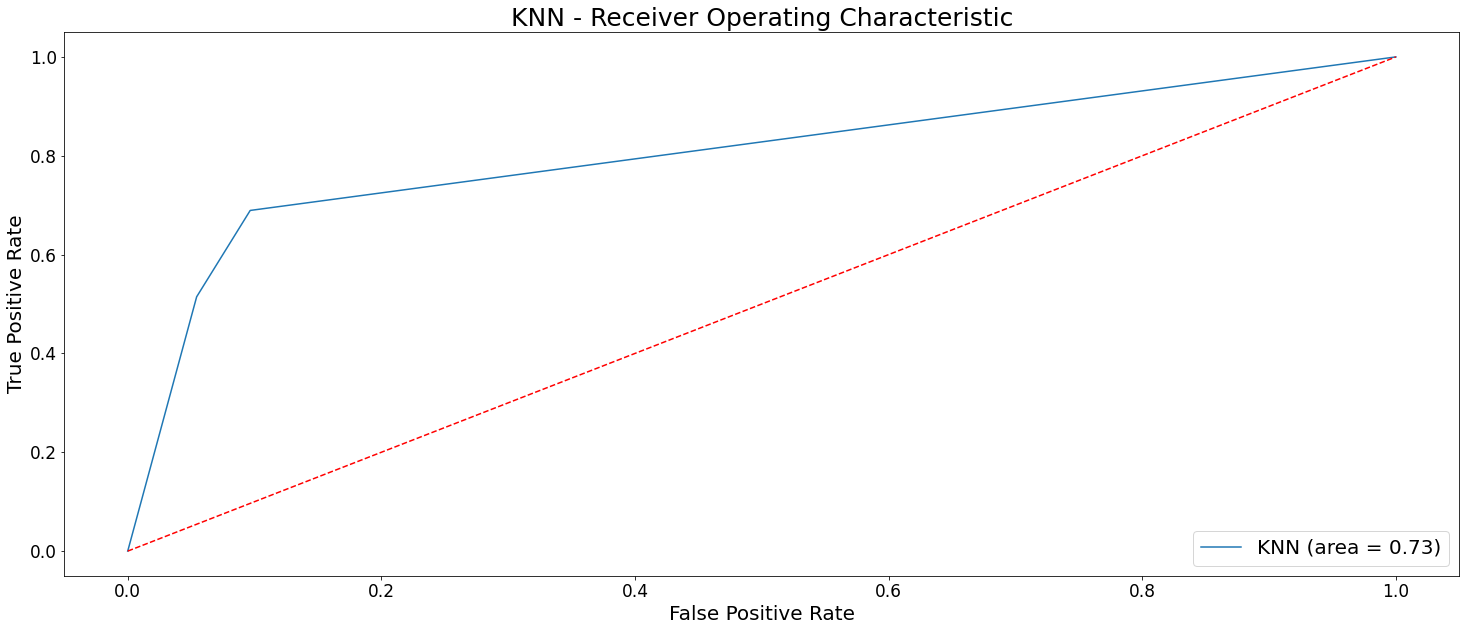

In [66]:
# Predict
knn_pred = best_model.predict(X_test)
knn_prob = best_model.predict_proba(X_test)
print('KNN - Hyper Parameter Tuning\n')
print('Accuracy on test set: {:.2f}'.format(best_model.score(X_test, y_test)))
print('-------------------------------------------------------')
confusion_matrix = pd.crosstab(y_test['Target'].to_numpy(), knn_pred, rownames=['Target'], colnames=['pred'])
print('Confusion Matrix')
print(confusion_matrix)

tn = confusion_matrix.iloc[0][0] 
tp = confusion_matrix.iloc[1][1]
true_preds = tn + tp
print('\nTrue Predictions: ', true_preds)

fp = confusion_matrix.iloc[0][1]
fn = confusion_matrix.iloc[1][0]
false_preds = fp + fn
print('False Predictions: ', false_preds)

print('-------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test['Target'], knn_pred))

# ROC Plot
roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
print('Threshold:', thresholds)
print('AUC:', round(metrics.auc(fpr, tpr),2))
plt.figure()
plt.rcParams['figure.figsize'] = (25, 10)
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('KNN - Receiver Operating Characteristic',fontsize=25)
plt.legend(loc="lower right",fontsize=20)
plt.tick_params(labelsize=17)
plt.show()